## FastCampus PJT - Team 3
##### 심성식 김민수 심승현 이희상 이용기

### 라이브러리 관련 및 환경 셋업

###### 필요한 모듈 설치

In [ ]:
# !pip install numpy
# !pip install pandas
# !pip install matplotlib
# !pip install scipy
# !pip install seaborn
# !pip install openpyxl

###### 필요한 모듈 모두 불러오기

In [1]:
import os
import time
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
import numpy as np
import pandas as pd
import urllib.request
from matplotlib import rc
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import re
import glob
import seaborn as sns
import datetime
import csv

###### 폰트 확인

In [2]:
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
font_path = fm.findfont('AppleGothic')
if not font_path:
    print('Warning: AppleGothic font not found')
else:
    print("AppleGothic font found at ", font_path)

font_prop = fm.FontProperties(fname=font_path, size=12)


AppleGothic font found at  /System/Library/Fonts/Supplemental/AppleGothic.ttf


### 경로 설정

###### 폴더 생성 및 경로 variable 생성

In [3]:
# Creating folders and variables for data paths

dataset = "./dataset/"
GROUPED = dataset + "Grouped/"
FINAL_GROUP = dataset + "Grouped_Final/"

if not os.path.exists("./dataset"):
    os.mkdir("./dataset")

if not os.path.exists(dataset + "Grouped"):
    os.mkdir(dataset + "Grouped")

if not os.path.exists(dataset + "Grouped_Final"):
    os.mkdir(dataset + "Grouped_Final")

###### 파일 경로 불러올 딕셔너리 생성

In [4]:
# Adding up all file locations into a dictionary.

file_locations = {
    "dataset" : dataset,
    'grouped': GROUPED,
    'group_final' : FINAL_GROUP #,
    # to be added further
}

all_file_locations = {}
for key, value in file_locations.items():
    all_file_locations[key] = glob.glob(value + "*.csv")

'''

type all_file_locations["key"] to call
keys are "dataset", "grouped", "group_final", etc.; to be added further.

'''

'\n\ntype all_file_locations["key"] to call\nkeys are "dataset", "grouped", "group_final", etc.; to be added further.\n\n'

#### 준비

###### Definition 설정

In [5]:
# Local definitions - 1

def clean_course_name(course_name):
    '''
    course name 중 첫 구절이 ( 으로 시작하고, 
    ~ 로 스플릿한 구절 중 0번째 len이 7인 경우; 예시: "(220123"
    ) 이후의 course name을 return합니다.
    
    아래와 같이 사용해 주시면 편합니다.
    df["course_name"] = df["course_name"].apply(clean_course_name)

    '''
    if course_name.startswith("("):
        # Classify the date range to cleanse.
        if "~" in course_name:
            temp = course_name.split("~")[0]
            # if the value before ~ is in year format, remove the whole bracket.
            if len(temp) == 7:
                return course_name.split(")")[1]
            else:
                return course_name
        else:
            return course_name
    else:
        return course_name

In [6]:
# Local definitions - 2

def course_packages(row):
    '''
    패키지명을 return하는 코드입니다.
    
    아래와 같이 apply 해주시고 적용 희망하시는 row를 대치시켜주시면 됩니다.
    df["course_group"] = df.apply(course_packages, axis=1)
    
    '''
    # Splitting course classifier (: and -) to extract package name
    parts = re.split("[:|-]", row["course_name"])
    # Finding course names without package classifier
    if len(parts) <= 1:
        # [무료강의] as an exception, it makes more sense if we classify itself alone.
        if parts[0].startswith("[무료강의]"):
            return "[무료강의]"
        # Classify all other courses without package classifier into Other.
        return ("Other")
    # Finding course names with package classifier.
    elif len(parts) > 1:
        # Classify [kit] first, as it needs to be separated from other [ ] covered words.
        if parts[0].startswith("[kit]"):
            return "[kit]"
        # Removing (( ))
        elif parts[0].startswith("(("):
            return parts[0].split("))")[1]
        # Removing ( )
        elif parts[0].startswith("("):
            return parts[0].split(")")[1]
        # Removing [ ]
        elif parts[0].startswith("["):
            return parts[0].split("]")[1]
        else:
            return parts[0]
    else:
        return parts[0]


In [7]:
# Local definitions - 3

def coupons(df):
    '''
    coupon name을 통해 특수 형태의 쿠폰 분류,
    예외의 경우, 타 column 활용하여 쿠폰 분류
    
    아래와 같이 사용해 주시면 편합니다.
    df = coupons(df)
    
    '''
    # Find the length of DataFrame
    for i in range(len(df)):
        # Counter Set
        found = False
        # if dict key is in coupon name, insert dict value in coupon type
        if isinstance(df["coupon_name"][i], str):
            for key, value in external_coupons.items():
                if key in df["coupon_name"][i]:
                    df.at[i, "coupon_type"] = value
                    # counter
                    found = True
                    break
            else:
                for key, value in internal_coupons.items():
                    if key in df["coupon_name"][i]:
                        df.at[i, "coupon_type"] = value
                        found = True
                        break
        # if not found from the above,
        if not found:
            # first, set all remaining coupon's type as general
            if isinstance(df["coupon_name"][i], str):
                df.at[i, "coupon_type"] = "general"
            # then, find 100% discount coupon and assign it as "free"
            if df["actual_sold_price"][i] == 0.0 and df["transaction_amount"][i] == 0.0:
                df.at[i, "coupon_type"] = "free"
            # then, find % discount coupons and assign it as its percent
            if isinstance(df["coupon_discount"][i], float) and isinstance(df["coupon_name"][i], str) and "%" in df["coupon_name"][i]:
                df.at[i, "coupon_type"] = f"{df['coupon_name'][i].split('%')[0][-2:]} percent"
            else:
                continue
    return df


###### 컬럼명 영문으로 변경 - Encoding 이슈 방지

In [8]:
# Changing column names from Korean to English

df = pd.read_csv('./eda-proj-fc-purchase.csv')
df.rename(columns={"거래id":"transaction_id", "유형":"l_type", "고객id":"customer_id","코스ID":"courseID","사이트":"site", "포맷":"l_format",
                   "카테고리":"l_categories", "코스(상품) 이름":"course_name", "거래일자":"transaction_date_time","쿠폰이름":"coupon_name",
                   "판매가격":"sold_price","결제수단":"payment_method","실거래금액":"actual_sold_price","쿠폰할인액":"coupon_discount",
                   "거래금액":"transaction_amount","환불금액":"refund_amount"
                   },
          inplace=True)
df.to_csv(dataset + "rawdata_eng.csv", index=False)

###### 사전 데이터 탐색

- 이어드림 과정에서 배운 다양한 분석기법을 활용하고 학습하고 주제로 이어지는 의미 있는 데이터를 추출을 목적으로 수행

### 우리가 주목한 데이터

In [9]:
df.l_categories.value_counts()

프로그래밍       51705
데이터 사이언스    26859
일러스트        15443
영상/3D       13923
업무 생산성      13916
마케팅         12896
부동산/금융      10797
디자인         10211
투자/재테크       2483
부업/창업        1094
크리에이티브          1
Name: l_categories, dtype: int64

In [10]:
grouped = df.groupby("l_categories")
df_temp = pd.DataFrame()
df_temp["count"] = grouped.size()
df_temp["home_lecture_num"] = grouped["course_name"].nunique()
df_temp["c_count"] = grouped.size() / len(df) * 100
df_temp["h_count"] = grouped["course_name"].nunique() / df["course_name"].nunique() * 100

df_temp = df_temp.sort_values(by="count", ascending=False)
df_temp

,count,home_lecture_num,c_count,h_count
l_categories,,,,
프로그래밍,51705,92,32.451923,22.604423
데이터 사이언스,26859,82,16.857677,20.147420
일러스트,15443,36,9.692584,8.845209
영상/3D,13923,51,8.738577,12.530713
업무 생산성,13916,30,8.734184,7.371007
마케팅,12896,37,8.093995,9.090909
부동산/금융,10797,33,6.776587,8.108108
디자인,10211,30,6.408792,7.371007
투자/재테크,2483,11,1.558420,2.702703


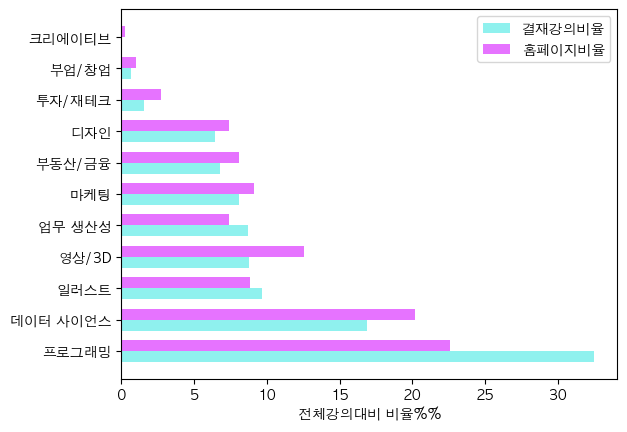

In [11]:
x_label = df_temp.index
x = np.arange(len(x_label))
y_1 = df_temp['c_count']
y_2 = df_temp['h_count']
# 넓이 지정
width = 0.35
# subplots 생성
fig, axes = plt.subplots()
# 넓이 설정
axes.barh(x - width/2, y_1, width, align='center', alpha=0.5, color=(33/255,229/255,222/255))
axes.barh(x + width/2, y_2, width, align='center', alpha=0.8, color=(224/255,80/255,255/255))
# xtick 설정
plt.yticks(x)
axes.set_yticklabels(x_label)
plt.xlabel('전체강의대비 비율%%')
plt.title('')
plt.legend(['결재강의비율', '홈페이지비율'])
plt.show()

# 전처리

###### 날짜/시간 데이터 변환 및 분리

In [12]:
# Converting date_time to date and time.

rawdata = pd.read_csv(dataset+"rawdata_eng.csv")

df = rawdata['transaction_date_time'].str.split(" ", n=5, expand=True)
print(df)
rawdata['FullDate'] = df[0].str.cat([df[1], df[2]], sep="")
rawdata['year'] = df[0].replace(".","")
rawdata['month'] = df[1].replace(".","")
rawdata['day'] = df[2].replace(".","")

rawdata['FullTime'] = df[3].str.cat([df[4]], sep=" ")
times = df[4].str.split(":", expand=True)
rawdata["hour"] = times[0]
rawdata["minute"] = times[1]
rawdata["second"] = times[2]
# Converting time to 24H format

rawdata["FullTime"] = rawdata["FullTime"].str.replace("오후", "PM").str.replace("오전","AM")
rawdata['FullTime'] = rawdata['FullTime'].apply(lambda x: datetime.datetime.strptime(x, '%p %I:%M:%S').strftime('%H:%M:%S'))
df = rawdata
# rawdata.to_csv(dataset + "rawdata.csv", index=False)

            0    1    2   3         4
0       2022.  12.  31.  오후  10:12:33
1       2022.  12.  30.  오후   6:12:57
2       2022.  12.  31.  오후  11:12:15
3       2022.  12.  31.  오후  11:12:03
4       2022.  12.  31.  오후  11:12:10
...       ...  ...  ...  ..       ...
159323  2022.   1.   1.  오전  12:01:08
159324  2022.   1.   1.  오전  12:01:12
159325  2022.   1.   1.  오전  12:01:21
159326  2022.   1.   2.  오전  11:01:24
159327  2022.   1.  24.  오전   4:01:00

[159328 rows x 5 columns]


###### 불필요한 데이터 처리

In [13]:
# Deleting Rows

# 크리에이티브
print("Number of rows before deletion:", len(df))
df = df[df["l_categories"] != "크리에이티브"]
print("Number of rows after deletion:", len(df))

# Format 컬럼

df = df.drop("l_format", axis=1)
df = df.drop("l_type", axis=1)

# rowdata_eng.to_csv(dataset + "columns_deleted.csv", index=False)

Number of rows before deletion: 159328
Number of rows after deletion: 159327


###### 숫자 데이터 컬럼 형 변환 (Obj -> Float)

In [14]:
# Convert dtype
df = df.replace("-",np.nan)
df["sold_price"] = df["sold_price"].astype(float)
df["actual_sold_price"] = df["actual_sold_price"].astype(float)
df["coupon_discount"] = df["coupon_discount"].astype(float)
df["transaction_amount"] = df["transaction_amount"].astype(float)
df["refund_amount"] = df["refund_amount"].astype(float)
type_converted = df
# type_converted.to_csv(dataset + "space_PLEASE.csv", index=False)

###### 코스 이름 컬럼 cleansing

In [15]:
# Removing date range in course_name

type_converted["course_name"] = type_converted["course_name"].apply(clean_course_name)
df_yes_space = type_converted
df_yes_space
df_yes_space.to_csv(dataset +"df_yes_space.csv", index = False)

###### 패키지 별 분류

In [16]:
# Grouping courses by Packages

# "The Red" had many variances, needed to cleanse the course_name once again solely for this
df_yes_space["course_name"] = df_yes_space["course_name"].apply(lambda x: x.replace(" ", "").lower())
df_no_space = df_yes_space

# Applying def course_packages.
df_no_space["course_group"] = df_no_space.apply(course_packages, axis=1)
df_no_space["course_name"] = rawdata["course_name"]
df_no_space.to_csv(dataset +"Packages_Separated.csv", index = False)

# Generating CSV file for each Package.
grouped_df = df_no_space.groupby("course_group")

for group_name, group_df in grouped_df:
    if group_name == "Other":
#     groupname = group_name.replace("/", "_")
        filename = f"{group_name}.csv"
        group_df.to_csv(GROUPED + f"{filename}", index=False)
    else:
        pass

###### 패키지 별 분류된 CSV파일 생성

In [17]:
# Some packages only had one course each, needed to re-classify them as others
for file in all_file_locations["grouped"]:
    df = pd.read_csv(file, low_memory=False)
    # print(file, file.split("/")[-1].split(".")[0] ,len(set(df["course_name"])))

df_new = pd.DataFrame()
for group_name, group_df in grouped_df:
    # We don't need to check Other.csv as we want to add more data to it
    if group_name == "Other":
        continue
    else:
        # Check if any Package has only one course
        if len(set(group_df["course_name"])) == 1:
            # There is only one course in [무료강의], but as it seemed more legit if we separate it from Others.
            if group_name == "[무료강의]":
                # Adding up [무료강의].csv to final CSV folder
                group_df.to_csv(FINAL_GROUP + "[무료강의].csv", index=False)
                pass
            else:
                # Add all packages that only has one course to df_new
                df_new = pd.concat([df_new, group_df])
                

        else:
            # Adding all the packages with multiple courses to the final CSV folder.
            filetitle = group_name.replace("/", "_")
            group_df.to_csv(FINAL_GROUP + f"{filetitle}.csv", index=False)

df_other = pd.read_csv(GROUPED + "Other.csv")
df_all = pd.concat([df_new, df_other])
df_all.to_csv(FINAL_GROUP + "Others.csv", index=False)

###### 쿠폰 분류 추가

In [18]:
internal_coupons = {"내부" : "internal",
                    "검수" : "internal",
                    "검토" : "internal",
                    "협업" : "internal",
                    "업무" : "internal",
                    "참고" : "internal",
                    "직원" : "internal",
                    "강사" : "internal",
                    "QA" : "internal",
                    "테스트" : "internal",
                    "조교" : "internal",
                    "test" : "internal",
                    "마케팅" : "internal",
                    "신해동" : "internal"
                   }
external_coupons = {"WELCOME" : "welcome",
                    "welcome" : "welcome",
                    "Welcome" : "welcome",
                     "페이백" : "payback",
                     "1+1" : "bogo",
                     "산학" : "univ",
                     "기수강자" : "return",
                     "미리보기" : "preview",
                     "100%": "free",
                     "무료" : "free"
                    }

In [19]:
df = pd.read_csv(dataset + 'Packages_Separated.csv') #추가할 데이터 부르기

df = coupons(df)
df.to_csv(dataset+"final_prep_file.csv")

###### 패키지, 쿠폰 타입 별 판매 수량

In [20]:
df_per_type_sold = pd.read_csv(dataset + "final_prep_file.csv")

grouped = df_per_type_sold.groupby("course_group")
df_temp = pd.DataFrame()
df_temp["package_count"] = grouped.size()
df_temp = df_temp.sort_values(by="package_count",ascending=False)

df_temp

,package_count
course_group,
초격차패키지,70380
올인원패키지,48043
thered,12392
Other,7516
네오아카데미,4815
편집하는여자의영상편집마스터클래스,2206
class,1793
live2d로만드는버츄얼캐릭터,1241
next.js완전정복,911


In [21]:
grouped_2 = df_per_type_sold.groupby("coupon_type")
df_temp2 = pd.DataFrame()
df_temp2["coupon_type_count"] = grouped_2.size()
df_temp2 = df_temp2.sort_values(by="coupon_type_count", ascending=False)

df_temp2

,coupon_type_count
coupon_type,
welcome,26177
bogo,16370
general,13704
payback,7729
free,4089
20 percent,3211
50 percent,2366
internal,1066
30 percent,451


# 주제와 관련된 데이터 탐색

## 주 수요층 분석을 통한 매출증대 전략
### 주 고객은 누구인가?

###### 카테고리별 매출 비교

<Axes: title={'center': '모든 카테고리별 총 매출'}, xlabel='l_categories', ylabel='actual_sold_price'>

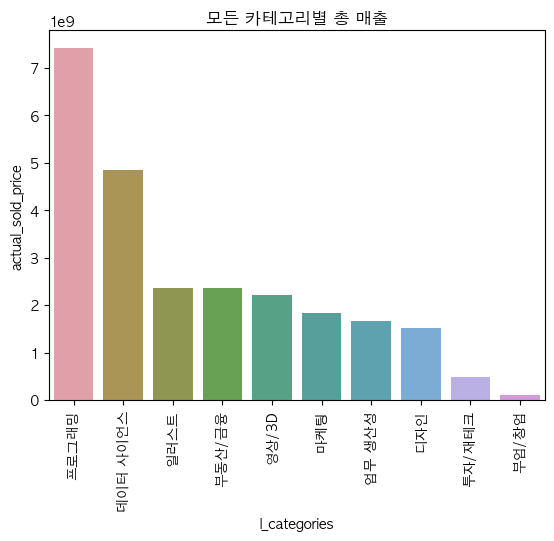

In [45]:
df = df_vis[df_vis.refund_amount.isnull()]
temp = df[["l_categories" , "sold_price" , "actual_sold_price" ,"coupon_discount" , "transaction_amount", "refund_amount"]]
temp2 = temp.groupby("l_categories").sum().reset_index()
plt.title("모든 카테고리별 총 매출")
plt.xticks(rotation=90)
sns.barplot(data = temp2.sort_values("actual_sold_price",ascending=False) , x = "l_categories" , y = 'actual_sold_price' , \
            palette = ["#EA96A3" ,"#B89C49", "#98A246", "#60AE47", "#4AAE8A", "#4BABA4", "#4FABBC", "#6DAEE2", "#B6A8EB","#DF8FE7","#E890C6"] )

([<matplotlib.patches.Wedge at 0x28122e980>,
 [Text(0.5529029483946164, 0.9509460182663054, '데이터 사이언스'),
  Text(1.0690696507026944, 0.25901753212170653, '디자인'),
  Text(1.0806937431388015, -0.20518536385582337, '마케팅'),
  Text(0.8281194941638262, -0.7240290763400657, '부동산/금융'),
  Text(0.5653478523039238, -0.943600448227607, '부업/창업'),
  Text(0.3400578496168489, -1.0461169432305188, '업무 생산성'),
  Text(-0.19349298371395393, -1.082848311285321, '영상/3D'),
  Text(-0.75518314388941, -0.7998114897807526, '일러스트'),
  Text(-0.9892414416383923, -0.481041962977447, '투자/재테크'),
  Text(-0.9398640110411554, 0.5715379608999137, '프로그래밍')],
 [Text(0.351847330796574, 0.605147466169467, '19.5%'),
  Text(0.6803170504471691, 0.16482933862290414, '6.1%'),
  Text(0.6877142001792371, -0.13057250427188757, '7.4%'),
  Text(0.5269851326497075, -0.46074577585276905, '9.5%'),
  Text(0.359766815102497, -0.6004730125084771, '0.5%'),
  Text(0.2164004497561765, -0.6657107820557847, '6.7%'),
  Text(-0.12313189872706157, -0.6

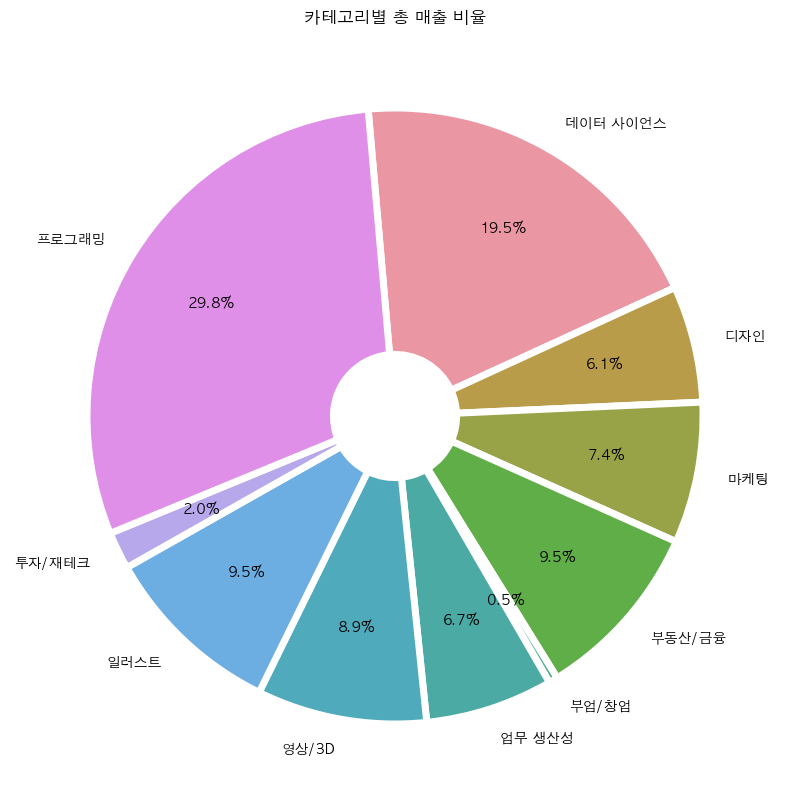

In [46]:
# 첫 구매로도 프로그래밍, 데사 ... 순임
plt.figure(figsize=(10,10))
plt.title("카테고리별 총 매출 비율")
plt.xticks(rotation=45)
wedgeprops={'width': 0.8, 'edgecolor': 'w', 'linewidth': 5}
explode = [0.10, 0, 0,0,0,0,0,0,0,0]
plt.pie(x=temp2["actual_sold_price"] / temp2["actual_sold_price"].sum() * 100 \
    , labels = temp2["l_categories"] , autopct='%.1f%%' , wedgeprops=wedgeprops,\
        textprops={'size':10}, pctdistance = 0.7, startangle = 95, counterclock = False,
        colors = ["#ea96a3" ,"#b89c49", "#98a246", "#60ae47", "#4aae8a", "#4baba4", "#4fabbc", "#6daee2", "#b6a8eb","#df8fe7","#e890c6"])

- **주고객** : **프로그래밍**과 **데이터사이언스 분야**
    - 강의구독수 와 매출의 상당부분을 차지하고 있다.
    
           프로그래밍 분야가 약 50% 차지 
    
           (프로그래밍 약 29.7% 데이터사이언스 19.4)

###### 2022년 카페고리별 첫구매 비율

([<matplotlib.patches.Wedge at 0x2817fd120>,
 [Text(-0.977582910541309, 0.5043130506120018, '프로그래밍'),
  Text(0.45096340494935744, 1.0033105239139486, '데이터 사이언스'),
  Text(1.0406774896820146, 0.35635707158570684, '영상/3D'),
  Text(1.0626109676711017, -0.284355290763307, '업무 생산성'),
  Text(0.7511319882978524, -0.803617282141017, '일러스트'),
  Text(0.2531920085366504, -1.0704642949735301, '마케팅'),
  Text(-0.25507849160439566, -1.0700163377821978, '부동산/금융'),
  Text(-0.6756910540610793, -0.8680101378796378, '디자인'),
  Text(-0.884993105755503, -0.6532895244569816, '투자/재테크'),
  Text(-0.9380834236179045, -0.5744558210457191, '부업/창업')],
 [Text(-0.6220982157990147, 0.320926486753092, '31.8%'),
  Text(0.28697671224050014, 0.6384703333997854, '16.5%'),
  Text(0.6622493116158275, 0.22677268191817704, '9.6%'),
  Text(0.6762069794270646, -0.18095336684937716, '9.2%'),
  Text(0.4779930834622697, -0.5113928159079199, '8.5%'),
  Text(0.1611221872505957, -0.6812045513467918, '8.0%'),
  Text(-0.16232267647552448,

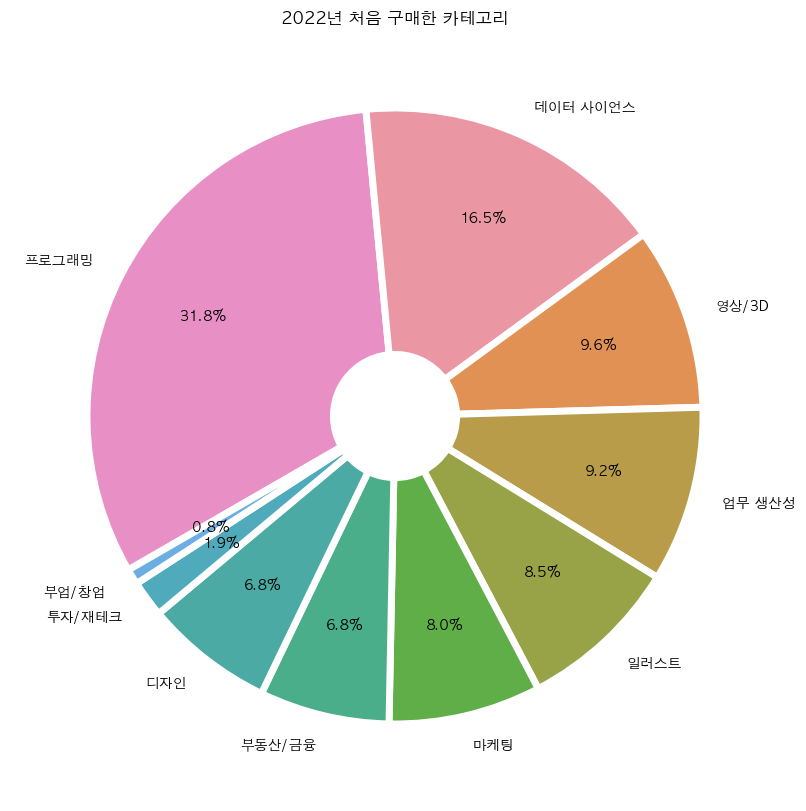

In [47]:
pay_df.columns
only_pay =pay_df[pay_df.refund_amount.isna()]
# 2022년 처음구매한 카테고리 pie
sort_df = only_pay.sort_values("FullTime")
# 2022년에 처음 구매한 정보
first_payment_mask = ~sort_df.duplicated("customer_id")
firts_pay_df = sort_df[first_payment_mask]
# 첫 구매로도 프로그래밍, 데사 ... 순임
plt.figure(figsize=(10,10))
plt.title("2022년 처음 구매한 카테고리")
plt.xticks(rotation=45)
wedgeprops={'width': 0.8, 'edgecolor': 'w', 'linewidth': 5}
explode = [0.10, 0, 0,0,0,0,0,0,0,0]
plt.pie(x=firts_pay_df.value_counts("l_categories").values /firts_pay_df.value_counts("l_categories").values.sum() * 100 \
    , labels = firts_pay_df.value_counts("l_categories").index , autopct='%.1f%%' , wedgeprops=wedgeprops,\
    textprops={'size':10}, pctdistance = 0.7, startangle = 210, counterclock = False,
    colors = ["#e890c6" , "#ea96a3" , "#e19153", "#b89c49", "#98a246", "#60ae47", "#4aae8a", "#4baba4", "#4fabbc", "#6daee2", "#b6a8eb","#df8fe7"])
    

###### 패스트 캠퍼스 홈페이지에 있는 상품의 Top10 태그비교.

In [48]:
# 시간 관계상 별도 모듈에서 실행 후 생성된 Excel 하단 블록에서 불러와서 사용
'''
driver = webdriver.Chrome()
# url = 'https://fastcampus.co.kr/category_online_datascience'
url = 'https://fastcampus.co.kr/category_online_programming'
driver.get(url)

ul_element = driver.find_element("class name", "card__labels")
li_elements = ul_element.find_elements("tag name", "li")
li_texts = [li.text for li in li_elements]

for text in li_texts:
    print(text)
card_containers = driver.find_elements("class name", "card__container")
data = []

for card_container in card_containers:
  
    card_title = card_container.find_element("class name", "card__title").text
    li_elements = card_container.find_elements("tag name", "li")
    li_texts = [li.text for li in li_elements]
    
    data.append((card_title, li_texts))

with open("data.csv", "w", newline="", encoding="utf-8-sig") as file:
    writer = csv.writer(file)
    writer.writerow(["제목", "태그"])
    
    for item in data:
        writer.writerow(item)
'''

'\ndriver = webdriver.Chrome()\n# url = \'https://fastcampus.co.kr/category_online_datascience\'\nurl = \'https://fastcampus.co.kr/category_online_programming\'\ndriver.get(url)\n\nul_element = driver.find_element("class name", "card__labels")\nli_elements = ul_element.find_elements("tag name", "li")\nli_texts = [li.text for li in li_elements]\n\nfor text in li_texts:\n    print(text)\ncard_containers = driver.find_elements("class name", "card__container")\ndata = []\n\nfor card_container in card_containers:\n  \n    card_title = card_container.find_element("class name", "card__title").text\n    li_elements = card_container.find_elements("tag name", "li")\n    li_texts = [li.text for li in li_elements]\n    \n    data.append((card_title, li_texts))\n\nwith open("data.csv", "w", newline="", encoding="utf-8-sig") as file:\n    writer = csv.writer(file)\n    writer.writerow(["제목", "태그"])\n    \n    for item in data:\n        writer.writerow(item)\n'

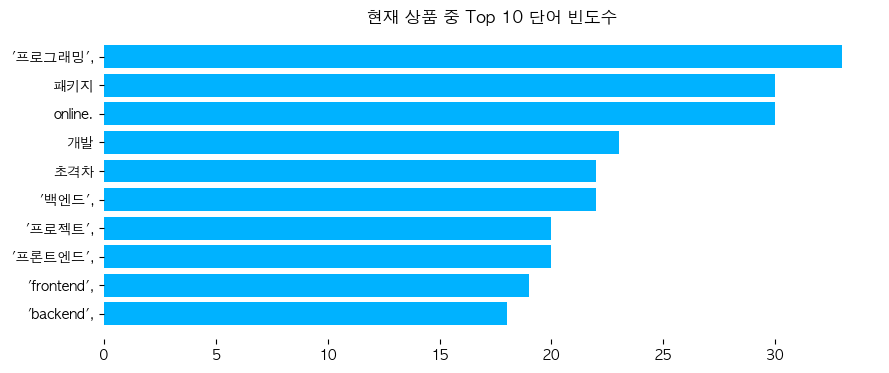

In [49]:
# 기존 전처리 완료 데이터
df = pd.read_csv(dataset + "final_prep_file.csv")
# 데이터 사이언스 태그 데이터
dstag_df = pd.read_csv('./data_datascience.csv')
#  프로그래밍 카테고리 태그 데이터
tag_df = pd.read_csv('./data.csv')

programming_courses = df[df['l_categories'] == '프로그래밍']
unique_course_names = programming_courses['course_name'].nunique()
num_titles = len(tag_df)
# print("프로그래밍 카테고리")
# print("제공된 상품 데이터 수:", unique_course_names)
# print("현재 패캠 상품 데이터 수:", num_titles)

# df 데이터프레임에서 카테고리가 '프로그래밍'인 '코스(상품) 이름'의 유니크한 값 추출
programming_courses = df[df['l_categories'] == '프로그래밍']
unique_course_names = programming_courses['course_name'].unique()

# tag_df 데이터프레임의 '제목' 컬럼 추출
tag_titles = tag_df['제목']

# 유니크한 값에서 다른 4개의 상품 이름 추출
diff_course_names = set(unique_course_names) - set(tag_titles)
diff_course_names = list(diff_course_names)[:4]

# 결과 출력
diff_course_names

programming_courses = df[df['l_categories'] == '프로그래밍']['course_name'].unique()
# 상품 이름 비교하여 일치하는 값을 추출
matching_courses = tag_df[tag_df['제목'].isin(programming_courses)]
count = len(matching_courses)
# print("상품 이름이 겹치는 데이터 수 :",count)

count = len(df[df['l_categories'] == '프로그래밍']['course_name'].unique())
count
df[df['l_categories'] == '프로그래밍']['course_name'].unique()

from collections import Counter
# '태그' 컬럼의 모든 값을 문자열로 결합하여 공백으로 구분된 하나의 문자열로 만듭니다
tag_string = ' '.join(tag_df['태그'].astype(str).tolist())
# 문자열을 공백으로 분리하여 단어로 분리합니다
words = tag_string.split()
# 단어의 빈도수를 계산합니다
word_counts = Counter(words)
# 가장 많이 등장하는 단어 1개와 그 빈도수를 출력합니다
most_common_word, count = word_counts.most_common(1)[0]
# print("가장 많이 등장하는 단어:", most_common_word)
# print("빈도수:", count)

# '제목' 컬럼과 '태그' 컬럼을 하나의 리스트로 합칩니다
combined_text = list(tag_df['제목']) + list(tag_df['태그'])

# 모든 단어를 소문자로 변환하여 카운트합니다 (':' 기호는 제외)
word_counts = Counter([re.sub(r':', '', word.lower()) for text in combined_text for word in text.split()])

# 가장 많이 등장하는 단어 10개를 추출합니다 (첫 번째 행 제외)
top_10_words = word_counts.most_common(11)[1:]

# 결과를 데이터프레임으로 변환하여 출력합니다
top_10_df = pd.DataFrame(top_10_words, columns=['단어', '빈도수'])
# print(top_10_df)

words = [word for word, _ in top_10_words[::-1]]
frequencies = [freq for _, freq in top_10_words[::-1]]

fig, ax = plt.subplots(figsize=(10, 4))
ax.barh(words, frequencies, color='#00b2ff')
ax.set_facecolor('white')
fig.patch.set_facecolor('white')

ax.set_title('현재 상품 중 Top 10 단어 빈도수', color='black')

ax.tick_params(axis='y', colors='black')

ax.set_facecolor('white')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.show()



첫 결제자의 수: 159327
재구매자의 수: 47262


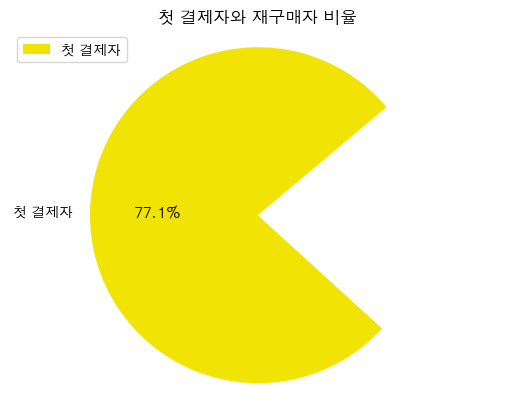

In [50]:
# 데이터프레임에서 필요한 컬럼 선택
df = pd.read_csv(dataset + "final_prep_file.csv")

selected_columns = ['customer_id', 'transaction_id']
df_selected = df[selected_columns]
# "고객id"를 기준으로 그룹화
grouped = df_selected.groupby('customer_id')
# 첫 결제자의 수
first_purchase_count = grouped['transaction_id'].nunique().sum()
# 재구매자의 수
repeat_purchase_count = grouped['transaction_id'].nunique().gt(1).sum()
print("첫 결제자의 수:", first_purchase_count)
print("재구매자의 수:", repeat_purchase_count)
selected_columns = ['customer_id', 'transaction_id']
df_selected = df[selected_columns]
grouped = df_selected.groupby('customer_id')
first_purchase_count = grouped['transaction_id'].nunique().sum()
repeat_purchase_count = grouped['transaction_id'].nunique().gt(1).sum()
data = [first_purchase_count, repeat_purchase_count]
labels = ['첫 결제자', '']
colors = ['#F1E405', '#fff']
explode = (0, 0)
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(data, labels=labels, colors=colors, autopct='%1.1f%%', startangle=40, explode=explode)
ax.set_title('첫 결제자와 재구매자 비율')
ax.axis('equal')
autotexts[1].set_color('white')
ax.legend(loc='upper left')
plt.show()

### 주어진 데이터에서의 매출 동향

/var/folders/0t/816d84452dn7h591gjkg32_m0000gn/T/ipykernel_86558/1733298482.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mask1 = mask1.append(null_rows)
/var/folders/0t/816d84452dn7h591gjkg32_m0000gn/T/ipykernel_86558/1733298482.py:17: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sns.lineplot(x = np.arange(0,12) , y = [pay_df.groupby('month').sum().reset_index()['actual_sold_price'].mean()] * 12  ,\
/var/folders/0t/816d84452dn7h591gjkg32_m0000gn/T/ipykernel_86558/1733298482.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the

<Axes: title={'center': '[월별] 쿠폰 할인 총 금액'}, xlabel='month', ylabel='coupon_discount'>

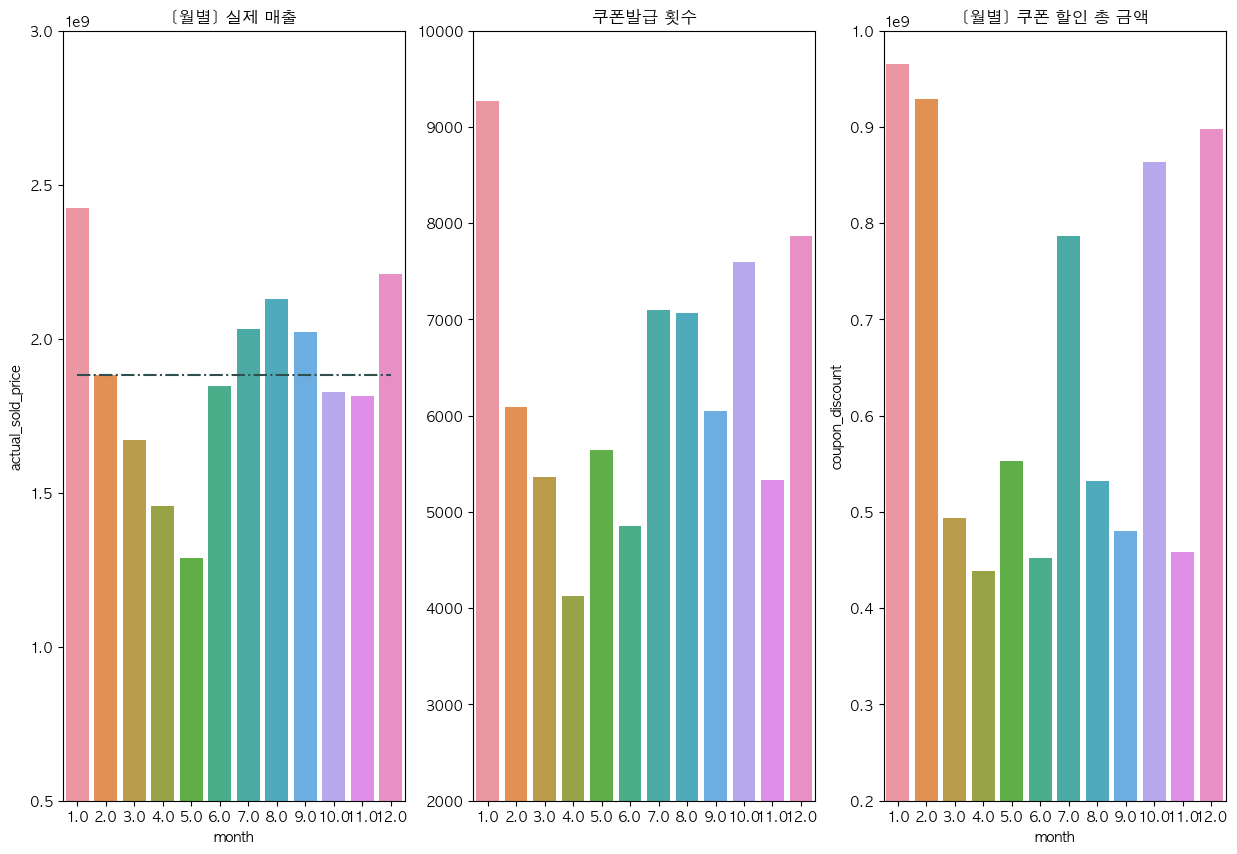

In [51]:
df_vis = pd.read_csv(dataset + "final_prep_file.csv")

mask1 = pd.DataFrame()
null_rows = df_vis[df_vis.isnull().any(axis=1)]
mask1 = mask1.append(null_rows)
mask1 = mask1.astype(bool) # Convert to boolean mask

pay_df = df_vis[mask1]

# 쿠폰 발급은 언제가 가장 많이 됨? 
use_coupon = pay_df[~pay_df["coupon_discount"].isna()]

plt.figure(figsize=(15,10))
plt.subplot(1,3,1)
plt.title("[월별] 실제 매출")
plt.ylim(0.5e9,3.0e9)
sns.lineplot(x = np.arange(0,12) , y = [pay_df.groupby('month').sum().reset_index()['actual_sold_price'].mean()] * 12  ,\
    color = "darkslategray", linestyle = "dashdot")
sns.barplot(data = pay_df.groupby('month').sum().reset_index() , x = "month" , y = 'actual_sold_price')

plt.subplot(1,3,2)
plt.title("쿠폰발급 횟수")
plt.ylim(2000,10000)
sns.barplot( x = use_coupon["month"].value_counts().index, y = use_coupon["month"].value_counts().values)


plt.subplot(1,3,3)
plt.title("[월별] 쿠폰 할인 총 금액")
plt.ylim(0.2e9,1.0e9)
sns.barplot(data = df.groupby('month').sum().reset_index() , x = "month" , y = 'coupon_discount')


- 12,1월, 7~9월 을 기준으로 하강

       5월에 하강하는 부드러운 곡선 형태를 그리고 있다.

- 쿠폰 발급횟수와 비슷한 형태의 그래프를 보이지만

       매출이 떨어지는 5,6월과 9,10월등 다소 차이 나는 부분이 있다.

- 2022년 이전의 데이터가 없어서 이 데이터가 주기성을 띄는지 알 수 없음.

        5월의 감소가 특이성을 보일 수 있다는 것을 전재로
        외출이 많은 날이나 코로나와 연관 시켜서 기상청 자료와
        코로나 대책본부 보고서를 참고 
        그러나 의미 있는 데이터를 얻지는 못함.

/var/folders/0t/816d84452dn7h591gjkg32_m0000gn/T/ipykernel_86558/3621231378.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sns.lineplot(data = pay_df.groupby('month').sum().reset_index() , x = pay_df.groupby('month').sum().reset_index().index, y = 'actual_sold_price',\
/var/folders/0t/816d84452dn7h591gjkg32_m0000gn/T/ipykernel_86558/3621231378.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sns.lineplot(data = pay_df.groupby('month').sum().reset_index() , x = pay_df.groupby('month').sum().reset_index().index, y = 'actual_sold_price',\
/var/folders/0t/816d84452dn7h591gjkg32_m0000gn/T/ipykernel_86558/3

<Axes: title={'center': '[월별] 실제 매출'}, xlabel='month', ylabel='actual_sold_price'>

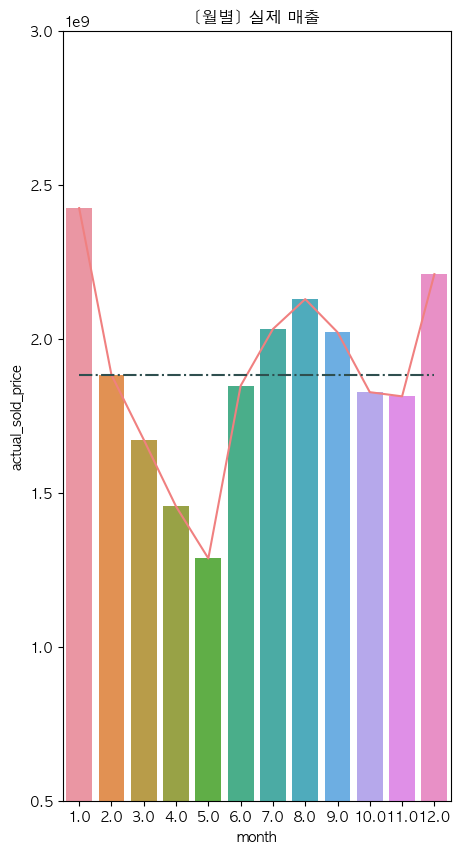

In [52]:
plt.figure(figsize=(5,10))
plt.title("[월별] 실제 매출")
plt.ylim(0.5e9,3.0e9)
sns.lineplot(data = pay_df.groupby('month').sum().reset_index() , x = pay_df.groupby('month').sum().reset_index().index, y = 'actual_sold_price',\
    color = "lightcoral" )
sns.lineplot(x = np.arange(0,12) , y = [pay_df.groupby('month').sum().reset_index()['actual_sold_price'].mean()] * 12  ,\
    color = "darkslategray", linestyle = "dashdot")
sns.barplot(data = pay_df.groupby('month').sum().reset_index() , x = "month" , y = 'actual_sold_price')

100%|█████████████████████████████████| 159327/159327 [00:28<00:00, 5676.17it/s]


([<matplotlib.axis.XTick at 0x2aaf9f0a0>,
 [Text(0, 0, '1월'),
  Text(1, 0, '2월'),
  Text(2, 0, '3월'),
  Text(3, 0, '4월'),
  Text(4, 0, '5월'),
  Text(5, 0, '6월'),
  Text(6, 0, '7월'),
  Text(7, 0, '8월'),
  Text(8, 0, '9월'),
  Text(9, 0, '10월'),
  Text(10, 0, '11월'),
  Text(11, 0, '12월')])

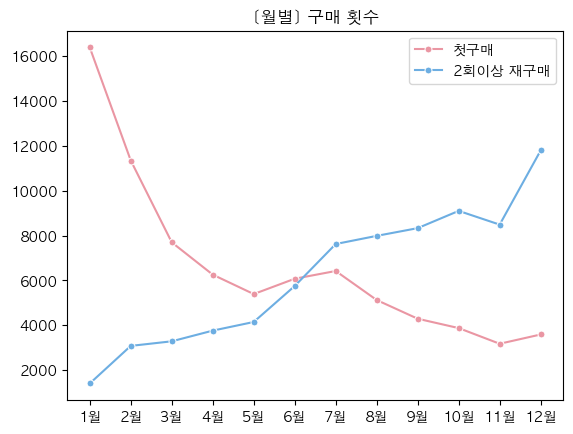

In [53]:
# 2022년 들어 프로그래밍을 구매한 이후 다른 강의를 구매한 수/비율
from datetime import datetime
from tqdm import tqdm
answer = []

# 시간별 정렬하기 위한 데이터 처리 
# for i in tqdm(range(len(pay_df))):
#   str_time = datetime(2022, pay_df.iloc[i]["month"], pay_df.iloc[i]["day"],\
#                       pay_df.iloc[i]["hour"],pay_df.iloc[i]["minute"],pay_df.iloc[i]["second"]).isoformat()
#   answer.append(str_time)
    
for i in tqdm(range(len(pay_df))):
    month = int(pay_df.iloc[i]["month"])
    day = int(pay_df.iloc[i]["day"])
    hour = int(pay_df.iloc[i]["hour"])
    minute = int(pay_df.iloc[i]["minute"])
    second = int(pay_df.iloc[i]["second"]) if not pd.isna(pay_df.iloc[i]["second"]) else 0
    str_time = datetime(2022, month, day, hour, minute, second).isoformat()
    answer.append(str_time)

pay_df["FullTime"] = answer
# 시간별 정렬 
# duplicate시 가장 시간이 빠른 정보만 남음 > 2022년 첫 구매는 무엇을 하였는가?
time_sort_df = pay_df.sort_values("FullTime")
first_pay_time_sort = time_sort_df.drop_duplicates("customer_id")
first_pay_mask = time_sort_df.duplicated("customer_id")
remove_first_pay_user = time_sort_df[first_pay_mask]
first_count = []
for i in range(1,13):
    first_count.append(len(first_pay_time_sort[first_pay_time_sort["month"] == i][["customer_id"]].drop_duplicates()))
    remove_count = []
for i in range(1,13):
    remove_count.append(len(remove_first_pay_user[remove_first_pay_user["month"] == i][["customer_id"]].drop_duplicates()) )
plt.title("[월별] 구매 횟수")
sns.lineplot(data = first_count, marker = "o" , color = "#ea96a3",label = "첫구매",markersize=5)
sns.lineplot(data = remove_count, marker = "o", color = "#6daee2", label = "2회이상 재구매",markersize=5)
# g.set_xticklabels(['1','2','3','4','5','6','7','8','9','10','11','12'])
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11] , ['1월','2월','3월','4월','5월','6월','7월','8월','9월','10월','11월','12월'])


### 주어진 데이터 외적으로 주고객에게 매출 상승 시킬 방안은?
- 프로그래머스 사이트의 경력개발자, 예비 개발자의 니즈를 채워줄 만한 일부 컨텐츠의 비율이 낮다. 

 - (출처: https://programmers.co.kr)


18 2 4 12 14


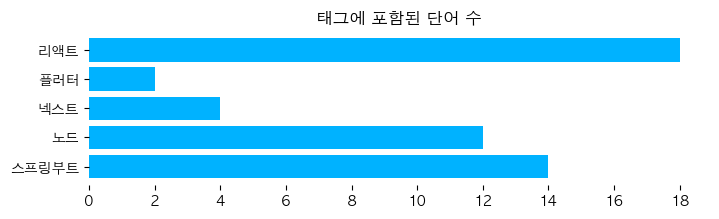

In [54]:
contains_react = tag_df[tag_df['제목'].str.contains('리액트|React|react', case=False) | tag_df['태그'].str.contains('리액트|React|react', case=False)]
contains_flutter = tag_df[tag_df['제목'].str.contains('플러터|Flutter|flutter', case=False) | tag_df['태그'].str.contains('플러터|Flutter|flutter', case=False)]
contains_next = tag_df[tag_df['제목'].str.contains('넥스트|Next|next|Next.js|next.js', case=False) | tag_df['태그'].str.contains('넥스트|Next|next|Next.js|next.js', case=False)]
contains_node = tag_df[tag_df['제목'].str.contains('노드|Node|node|Node.js|node.js', case=False) | tag_df['태그'].str.contains('노드|Node|node|Node.js|node.js', case=False)]
contains_springboot = tag_df[tag_df['제목'].str.contains('스프링부트|SpringBoot|Springboot|springboot', case=False) | tag_df['태그'].str.contains('스프링부트|SpringBoot|Springboot|springboot', case=False)]

count_react = len(contains_react)
count_flutter = len(contains_flutter)
count_next = len(contains_next)
count_node = len(contains_node)
count_springboot = len(contains_springboot)
print(count_react,count_flutter,count_next,count_node,count_springboot)

categories = ['리액트', '플러터', '넥스트', '노드', '스프링부트']
counts = [count_react, count_flutter, count_next, count_node, count_springboot]
counts_ticks = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18]

# 그래프 설정
fig, ax = plt.subplots(figsize=(8, 2))
ax.set_facecolor('white') 
fig.patch.set_facecolor('white')  # 전체 배경색을 검은색으로 설정
ax.barh(categories, counts, color='#00b2ff', linewidth=2, height=0.8)
ax.set_xticks(counts_ticks)  # x축 눈금 설정

# 그래프에 제목과 축 레이블 추가
ax.set_title('태그에 포함된 단어 수', color='black')


# 그래프 눈금과 레이블 색상 설정
ax.tick_params(colors='black')
ax.invert_yaxis()  # y축 뒤집기

# 그래프 배경색과 테두리 숨김
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.show()


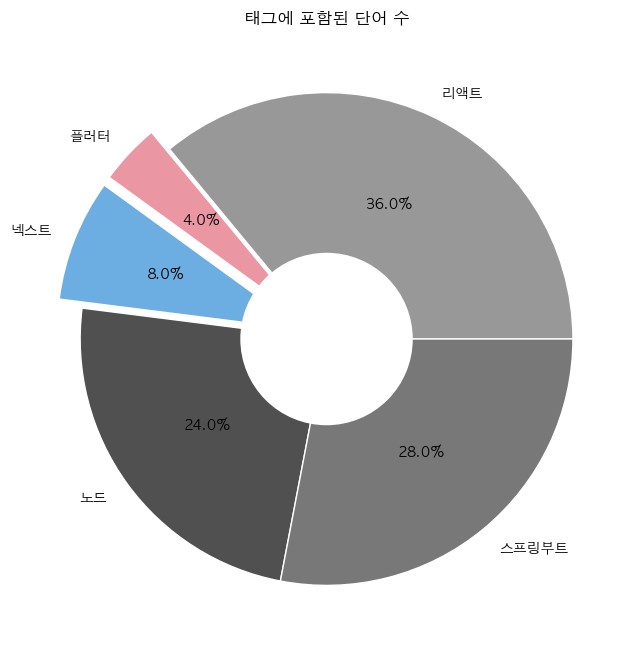

In [55]:
import matplotlib.pyplot as plt

categories = ['리액트', '플러터', '넥스트', '노드', '스프링부트']
counts = [count_react, count_flutter, count_next, count_node, count_springboot]
colors = ['#989898', '#ea96a3', '#6daee2', '#505050', '#787878']  # 각 항목의 색상 지정
explode = [0.1 if count in sorted(counts)[:2] else 0 for count in counts]

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_facecolor('white') 
fig.patch.set_facecolor('white')  

# 파이 차트 그리기
wedges, texts, autotexts = ax.pie(counts, labels=categories, colors=colors, autopct='%1.1f%%', startangle=0, explode=explode, wedgeprops={'edgecolor': 'white'})

# 도넛 형태로 가운데 뚫기
center_circle = plt.Circle((0, 0), 0.35, color='white', fc='white', linewidth=0)
fig.gca().add_artist(center_circle)

# 텍스트 색상 설정
for text, autotext in zip(texts, autotexts):
    text.set_color('black')
    autotext.set_color('black')

# 그래프에 제목 추가
ax.set_title('태그에 포함된 단어 수', color='black')

plt.show()

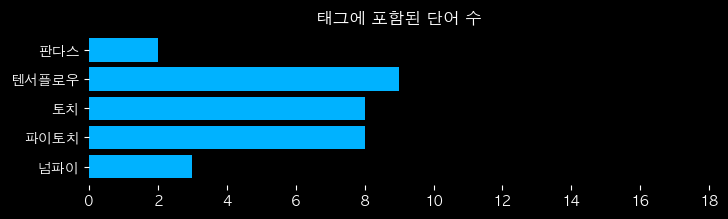

In [56]:
# '제목' 컬럼과 '태그' 컬럼을 하나의 리스트로 합칩니다
dscombined_text = list(dstag_df['제목']) + list(dstag_df['태그'])
# 모든 단어를 소문자로 변환하여 카운트합니다 (':' 기호는 제외)
dsword_counts = Counter([re.sub(r':', '', word.lower()) for text in dscombined_text for word in text.split()])

# 가장 많이 등장하는 단어 10개를 추출합니다 (첫 번째 행 제외)
dstop_10_words = dsword_counts.most_common(11)[1:]

# 'red'와 'the'를 제외한 결과를 데이터프레임으로 변환하여 출력합니다
dstop_10_df = pd.DataFrame([(re.sub(r'\s+', '', word.strip()), count) for i, (word, count) in enumerate(dstop_10_words[:10], start=1) if word.strip() and word.strip() not in ['red', 'the']], columns=['단어', '빈도수'])
# print(dstop_10_df)

contains_pandas = dstag_df[dstag_df['제목'].str.contains('판다스|Pandas|pandas', case=False) | dstag_df['태그'].str.contains('판다스|Pandas|pandas', case=False)]
contains_tensorflow = dstag_df[dstag_df['제목'].str.contains('텐서플로우|Tensorflow|tensorflow', case=False) | dstag_df['태그'].str.contains('텐서플로우|Tensorflow|tensorflow', case=False)]
contains_torch = dstag_df[dstag_df['제목'].str.contains('토치|Torch|torch', case=False) | dstag_df['태그'].str.contains('토치|Torch|torch', case=False)]
contains_pytorch = dstag_df[dstag_df['제목'].str.contains('파이토치|Pytorch|pytorch', case=False) | dstag_df['태그'].str.contains('파이토치|Pytorch|pytorch', case=False)]
contains_numpy = dstag_df[dstag_df['제목'].str.contains('넘파이|Numpy|numpy', case=False) | dstag_df['태그'].str.contains('넘파이|Numpy|numpy', case=False)]

count_pandas = len(contains_pandas)
count_tensorflow = len(contains_tensorflow)
count_torch = len(contains_torch)
count_pytorch = len(contains_pytorch)
count_numpy = len(contains_numpy)
# print("리액트:", count_pandas,"플러터:",count_tensorflow,count_torch,count_pytorch,count_numpy)

categories = ['판다스', '텐서플로우', '토치', '파이토치', '넘파이']
counts = [count_pandas, count_tensorflow, count_torch, count_pytorch, count_numpy]
counts_ticks = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18]

# 그래프 설정
fig, ax = plt.subplots(figsize=(8, 2))
ax.set_facecolor('black') 
fig.patch.set_facecolor('black')  # 전체 배경색을 검은색으로 설정
ax.barh(categories, counts, color='#00b2ff', linewidth=2, height=0.8)
ax.set_xticks(counts_ticks)  # x축 눈금 설정

# 그래프에 제목과 축 레이블 추가
ax.set_title('태그에 포함된 단어 수', color='white')


# 그래프 눈금과 레이블 색상 설정
ax.tick_params(colors='white')
ax.invert_yaxis()  # y축 뒤집기

# 그래프 배경색과 테두리 숨김
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.show()


### 주 고객층 분석을 통한 부진한 카테고리의 활성화 방안
- 투자/재테크, 부업/창업의 판매수 개선의 필요성
    - 프로래밍 구매자는 다른 분야에도 상당함 관심을 가지고 있다.
    - 주 고객층인 프로그래밍과 연계된 상품개발필요

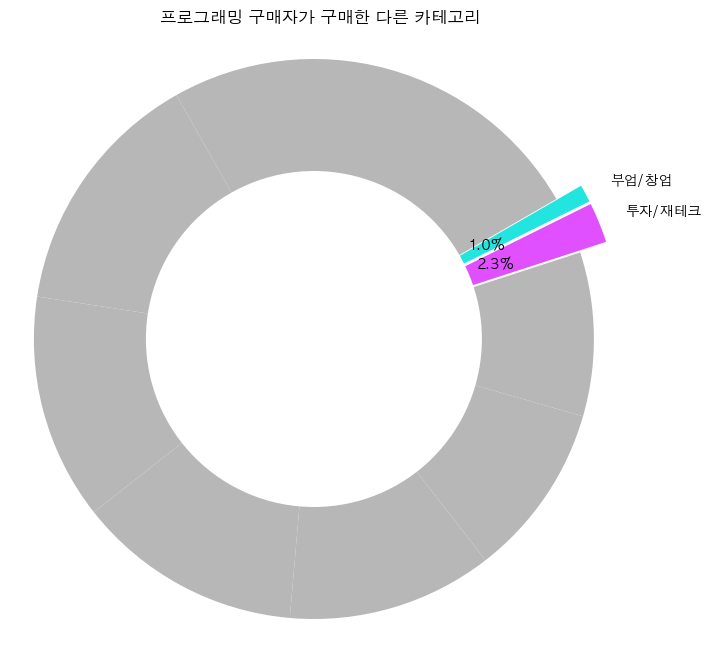

In [57]:
mask1 = df.l_categories == "프로그래밍"
extract_index = df[mask1].customer_id.values
extract_mask = df["customer_id"].apply(lambda x: True if x in extract_index else False)
new_data = df[extract_mask]["l_categories"].value_counts()[1:]
new_data = new_data
categories = new_data.index.values
sales_quantity = new_data.values
colors = ["#B7B7B7", "#B7B7B7", "#B7B7B7", "#B7B7B7", "#B7B7B7", "#B7B7B7", "#B7B7B7", "#B7B7B7", "#B7B7B7",  (224/255,80/255,255/255),(33/255,229/255,222/255)]
colors = colors[1:4] + colors[5:]  # Remove unwanted colors
explode = [0] + [0.1 if color != "#B7B7B7" else 0 for color in colors[1:]]
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(sales_quantity, labels=["", *categories[1:]], colors=colors, startangle=30, explode=explode,
                                  autopct=lambda pct: f"{pct:.1f}%" if pct <= 3.0 else '')
for text, autotext in zip(texts, autotexts):
    if text.get_text() == "부업/창업" or text.get_text() == "투자/재테크":
        text.set_color('black')
        autotext.set_color('black')
    else:
        text.set_text("")
centre_circle = plt.Circle((0, 0), 0.6, fc='white', linewidth=0)
fig.gca().add_artist(centre_circle)
plt.title("프로그래밍 구매자가 구매한 다른 카테고리")
plt.axis('equal')
plt.show()

<Axes: title={'center': '프로그래밍 구매자가 구매한 다른 카테고리'}>

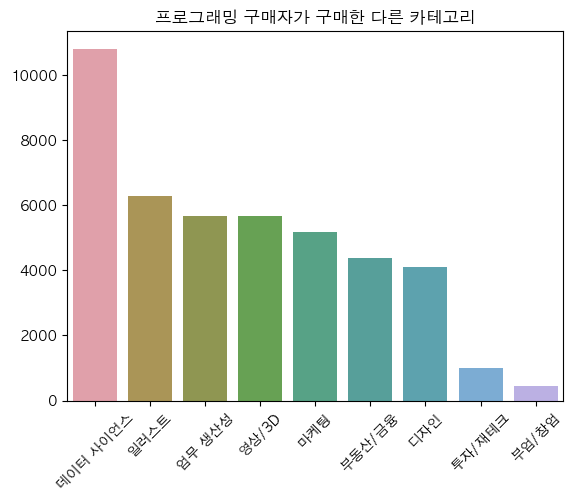

In [58]:
# 프로그래밍 구매자가 구매한 다른 카테고리
mask1 = df.l_categories == "프로그래밍"
extract_index = df[mask1].customer_id.values
extract_mask = df["customer_id"].apply(lambda x : True if x in extract_index else False)
new_data = df[extract_mask]["l_categories"].value_counts()[1:]
plt.title("프로그래밍 구매자가 구매한 다른 카테고리")
plt.xticks(rotation=45)
sns.barplot(x=new_data.index.values , y=new_data.values,
            palette = ["#EA96A3" ,"#B89C49", "#98A246", "#60AE47", "#4AAE8A", "#4BABA4", "#4FABBC", "#6DAEE2", "#B6A8EB","#DF8FE7","#E890C6"])

### 신 컨텐츠 개발을 통한 기대수익 증대

#### 데이터적으로 신콘텐츠 탐색

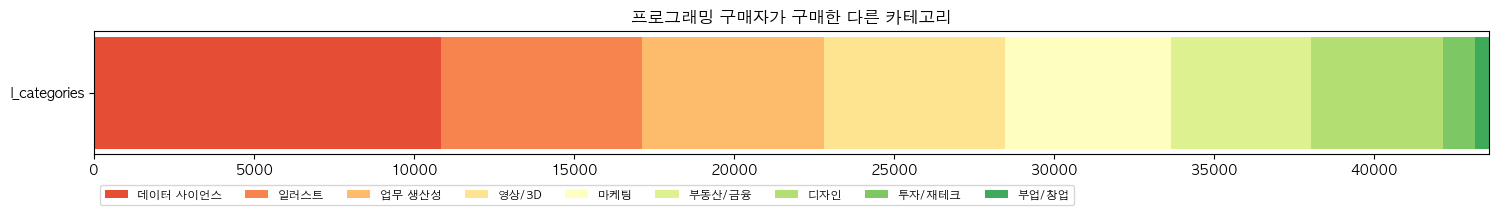

In [59]:
category_names = new_data.index.values[:9] # new_data 정의 : new_data = df_pay[extract_mask]["category"].value_counts()[1:] 
results = {
    'l_categories': new_data.values[:9]
}


def survey(results, category_names):
   
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.colormaps['RdYlGn'](
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(18, 1.6))
    ax.invert_yaxis()
    #ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts, height=0.5,
                        label=colname, color=color)

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        #ax.bar_label(rects,label_type='center', color=text_color,padding=-5)
    ax.legend(ncols=len(category_names), bbox_to_anchor=(0, -0.2),
              loc='upper left', fontsize='small')

    return fig, ax


survey(results, category_names)
plt.title("프로그래밍 구매자가 구매한 다른 카테고리")
plt.show()

### (그래프 변경남음)부동산

/var/folders/0t/816d84452dn7h591gjkg32_m0000gn/T/ipykernel_86558/3197680203.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temp3 = temp2.groupby("ovr").sum()


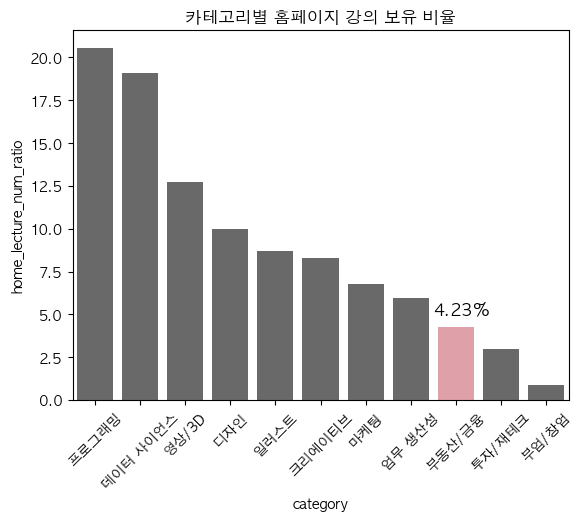

In [60]:
home_lecture = pd.read_excel('./hompage_Lecture_num.xlsx')
home_lecture["home_lecture_num_ratio"] = home_lecture["home_lecture_num"] / home_lecture["home_lecture_num"].sum() * 100
temp_home = home_lecture.sort_values("home_lecture_num_ratio",ascending=False)
temp_home[temp_home["category"] == "부동산/금융"]['home_lecture_num_ratio']
plt.title("카테고리별 홈페이지 강의 보유 비율")
plt.xticks(rotation = 45)
ax = sns.barplot(data = temp_home , x = "category" ,y = "home_lecture_num_ratio" , 
            palette = ["dimgray","dimgray","dimgray","dimgray","dimgray","dimgray","dimgray","dimgray","#ea96a3","dimgray","dimgray" ]
            )
plt.text(7.5, 5, str(temp_home[temp_home["category"] == "부동산/금융"]['home_lecture_num_ratio'].values[0])[:4] +"%", fontsize=12)
cat2 = temp2['l_categories'].apply(lambda x : 1 if x  == "부동산/금융" else 0)
temp2['ovr'] = cat2
temp3 = temp2.groupby("ovr").sum()

9.485666740739711

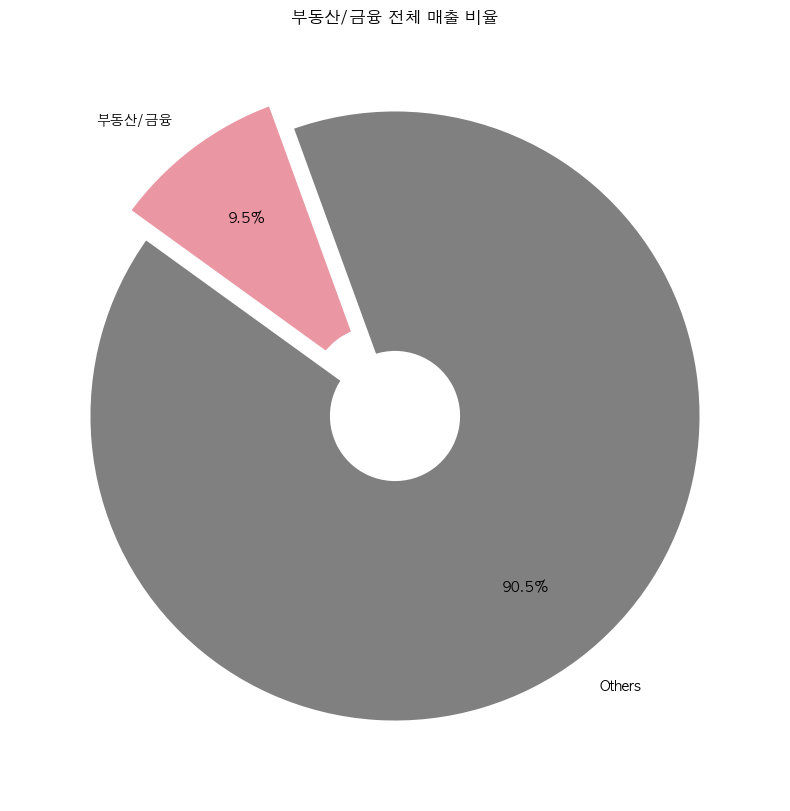

In [61]:
# 부동산/ 금융 

# 첫 구매로도 프로그래밍, 데사 ... 순임
plt.figure(figsize=(10,10))
plt.title("부동산/금융 전체 매출 비율")
plt.xticks(rotation=45)
wedgeprops={'width': 0.8, 'edgecolor': 'w', 'linewidth': 5}
explode = [0, 0.1]
plt.pie(x=temp3["actual_sold_price"]/temp3["actual_sold_price"].sum() * 100 \
    , labels = ["Others", "부동산/금융"] , autopct='%.1f%%' , wedgeprops=wedgeprops,\
        textprops={'size':10}, pctdistance = 0.7, startangle = 110, counterclock = False,
        explode= explode, colors = ["gray" ,"#ea96a3"])

(temp3["actual_sold_price"]/temp3["actual_sold_price"].sum() * 100)[1]

Text(0.9, 13, '9.48%')

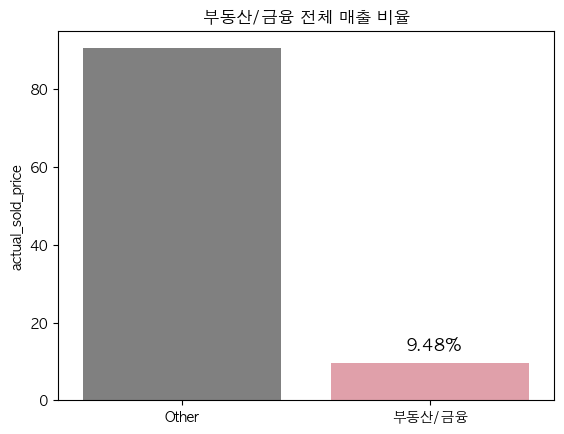

In [62]:
# 부동산/ 금융 

# 첫 구매로도 프로그래밍, 데사 ... 순임
plt.title("부동산/금융 전체 매출 비율")
explode = [0, 0.1]
ax = sns.barplot(x= ["Other","부동산/금융"],
    y = temp3["actual_sold_price"]/temp3["actual_sold_price"].sum() * 100, palette = ["gray" ,"#ea96a3"])
plt.text(0.9, 13, str((temp3["actual_sold_price"]/temp3["actual_sold_price"].sum() * 100)[1])[:4] +"%", fontsize=12)

<Axes: title={'center': '모든 카테고리별 총 매출'}, xlabel='l_categories', ylabel='actual_sold_price'>

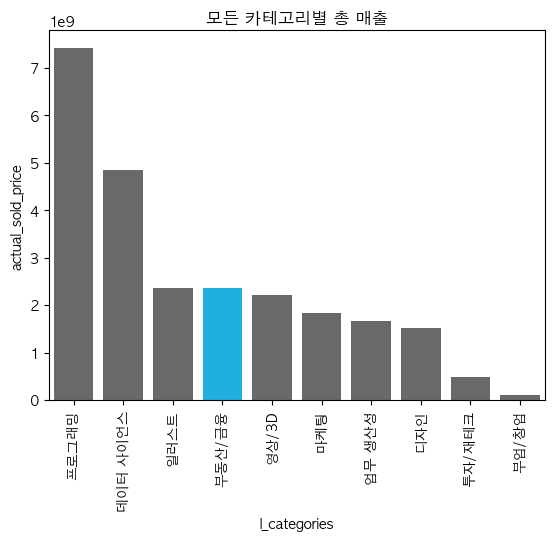

In [63]:
plt.title("모든 카테고리별 총 매출")
plt.xticks(rotation=90)
sns.barplot(data = temp2.sort_values("actual_sold_price",ascending=False) , x = "l_categories" , y = 'actual_sold_price' , \
    palette = ["dimgray","dimgray","dimgray","deepskyblue","dimgray","dimgray","dimgray","dimgray","dimgray","dimgray","dimgray" ] )

### 디자인 구매후 프로그래밍을 구매하지 않는디자인 콘텐츠만을 소비하는 층이 존재

/var/folders/0t/816d84452dn7h591gjkg32_m0000gn/T/ipykernel_86558/757316575.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_pay_2 = df_pay_2.append(null_rows)


<Axes: title={'center': '일러스트, 영상/3D, 디자인 구매자가 구매한 다른 카테고리'}>

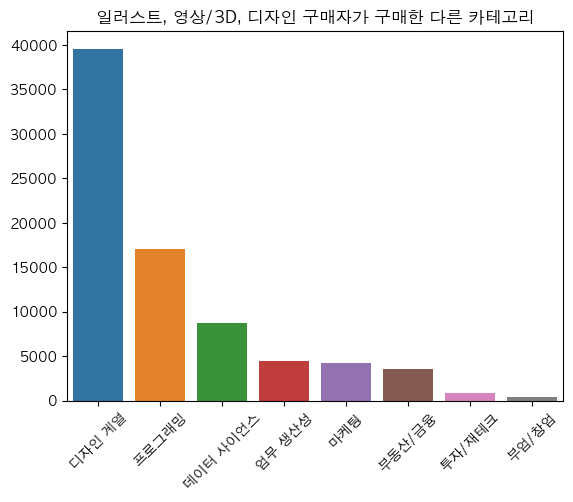

In [64]:
df_vis_2 = pd.read_csv(dataset + "final_prep_file.csv")

df_pay_2 = pd.DataFrame()
null_rows = df_vis_2[df_vis_2.isnull().any(axis=1)]
df_pay_2 = df_pay_2.append(null_rows)
# print(df_pay_2)
df_pay_2 = df_pay_2.astype(bool) # Convert to boolean mask
# df_pay_2
df_pay_2 = df_vis_2[df_pay_2]
df_pay_2.l_categories.unique()

# mask1 : 일러스트
# mask2 : 영상/3D
# mask3 : 디자인
mask1 = df_pay_2.l_categories == "일러스트"
mask2 = df_pay_2.l_categories == "영상/3D"
mask3 = df_pay_2.l_categories == "디자인"

extract_index = df_pay_2[mask1 | mask2 | mask3].customer_id.values

extract_mask = df_pay_2["customer_id"].apply(lambda x : True if x in extract_index else False)

result = df_pay_2[extract_mask]["l_categories"].value_counts()

# print(result)

# 디자인 계열 수치 보기위한 table 생성
new_result = result

new_result['디자인 계열'] = new_result[1] + new_result[2] + new_result[3]
new_result = new_result.sort_values(ascending=False)
new_result = new_result.drop(['일러스트','영상/3D','디자인'])
# print(new_result)
# 막대그래프 시각화
plt.rc('font', family='AppleGothic')

plt.title("일러스트, 영상/3D, 디자인 구매자가 구매한 다른 카테고리")
plt.xticks(rotation=45)

#sns.set_palette(sns.color_palette(colors))
sns.barplot(x = new_result.index.values, y=new_result.values)

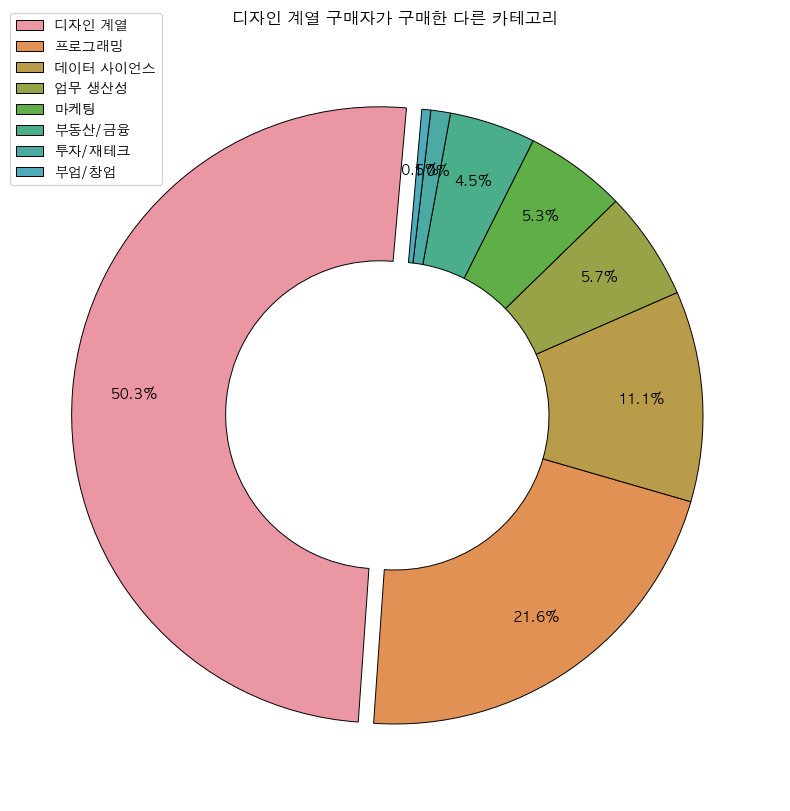

In [65]:
# 파이차트 시각화
wedgeprops={'width': 0.5, 'edgecolor': 'k', 'linewidth': 0.7}
explode = [0.05,0,0,0,0,0,0,0]
pctdistance = [0.8] * 8
plt.figure(figsize=(10,10))
plt.title('디자인 계열 구매자가 구매한 다른 카테고리')
colors = ["#EA96A3", "#E19153","#B89C49",'#98A246','#60AE47','#4AAE8A','#4BABA4','#4FABBC','#6DAEE2','#B6A8EB','#DF8FE7','#E890C6']

plt.pie(new_result,startangle=85, wedgeprops=wedgeprops,autopct = '%.1f%%',explode=explode,pctdistance=0.8,colors=colors)
plt.legend(new_result.index.values,loc = (0,0.8))


100%|████████████████████████████████| 148165/148165 [00:07<00:00, 18706.92it/s]


<Axes: title={'center': '디자인 구매자의 추가구매 성향'}>

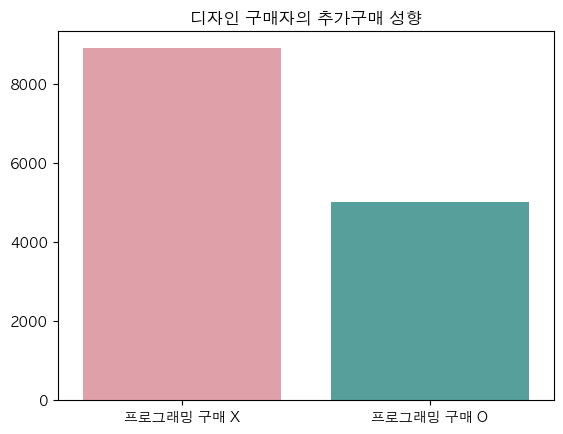

In [66]:
from tqdm import tqdm 
# 언제 샀던 상관없이 관심이 있다고 판단 
mask1 = only_pay.l_categories == "프로그래밍"
# 구매자 id 추출 
# 구매 내역에서 mask1:프로그래밍을 구매한 모든 유저 id 추출
extract_index = only_pay[mask1].customer_id.values

input_mask = []
for i in tqdm(range(len(only_pay))):
    if only_pay.iloc[i]["customer_id"] in extract_index:
        input_mask.append(True)
    else:
        input_mask.append(False)
        
# 프로그래밍을 한번이라도 구매한 사람의 모든 구매 내역
extract_df = only_pay[input_mask]

# extract_df : 프로그래밍을 한번이라도 구매한사람 
# df : 전체 
# df[영상/3D] - extract_df[영상/3D] = 프로그래밍을 한번이라도 구매하지 않은 사람 수
# print(len(only_pay[only_pay["l_categories"] == "영상/3D"]) - len(extract_df[extract_df["l_categories"] == "영상/3D"])) # 프로그래밍 구매를 하지 않은 사람들
# print(len(extract_df[extract_df["l_categories"] == "영상/3D"]))

plt.title("디자인 구매자의 추가구매 성향")
# plt.xticks(rotation=45)
sns.barplot(x = ["프로그래밍 구매 X", "프로그래밍 구매 O"] , y =[8907 , 5016], palette = ["#ea96a3" , "#4baba4"] )

### 데이터 외적으로 신 콘텐츠 탐색

100%|████████████████████████████████| 159327/159327 [00:08<00:00, 18667.01it/s]


7604
5388


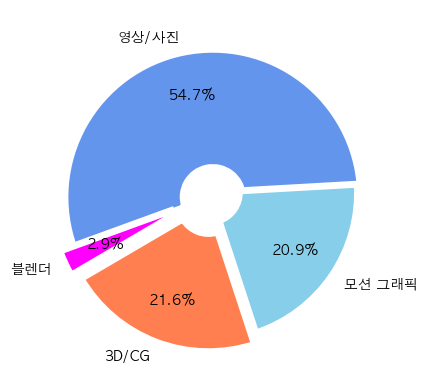

In [67]:
# 프로그래밍 강의 구매자가 구매한 영상/3D관련
from tqdm import tqdm 
input_mask = []
for i in tqdm(range(len(df))):
    if df.iloc[i]["customer_id"] in extract_index:
        input_mask.append(True)
    else:
        input_mask.append(False)
extract_df = df[input_mask]
program_buy_3d = extract_df[extract_df["l_categories"] == "영상/3D"]

# course name 
only_name = df[df['l_categories'] == "영상/3D"].drop_duplicates("course_name")["course_name"]
only_name = pd.DataFrame(only_name)
only_name["Division"] = np.nan

searchfor_vp = ['촬영', '편집', '영상' ,'카메라', '인스타', '프리미어프로', '비디오','유튜브',"십다 프리미어","이필성"]
searchfor_motion = ['모션그래픽', '그래픽' ,'아트웍', 'Cinema4D 포트폴리오' ]
searchfor_blender = ['블렌더']
searchfor_3d = ['픽셀게임', '아이패드 모델링', '제페토', '판타지 캐릭터', '게임 캐릭터', '매치무브 온보딩',
'히어로부터 크리쳐', '라이엇게임즈', 'Unity', '후디니 디스트럭션', '라이팅', '라이팅', '게임 배경의 모든 것', 'VFX', 'FX 아티스트', '게임 캐릭터 모델링' ]


answer = []
for index, i in enumerate(only_name['course_name']):
    if pd.Series(i).str.contains('|'.join(searchfor_vp)).values == True:
        answer.append("영상/사진")
        continue
    if pd.Series(i).str.contains('|'.join(searchfor_motion)).values == True:
        answer.append("모션그래픽")
        continue
    if pd.Series(i).str.contains('|'.join(searchfor_blender)).values == True:
        answer.append("블렌더")
        continue
    if pd.Series(i).str.contains('|'.join(searchfor_3d)).values == True:
        answer.append("3D.CG")
        continue
    answer.append(np.nan)

only_name["Division"] = answer
only_name["Division"].value_counts()

# 전체 데이터에 병합
merge_data = program_buy_3d.merge(only_name,how = "left")

# 소 카테고리별 구매 건수
merge_data[merge_data['l_categories'] == "영상/3D"]["Division"].value_counts()

ThreeD_total = merge_data[merge_data['l_categories'] == "영상/3D"]["Division"].value_counts()
ThreeD_total.index = ["영상/사진" , "3D/CG" , "모션 그래픽" , "블렌더"]
# ThreeD_total

index_list = [ThreeD_total.index[0] , ThreeD_total.index[2], ThreeD_total.index[1], ThreeD_total.index[3] ]
value_list = [ThreeD_total.values[0] , ThreeD_total.values[2], ThreeD_total.values[1], ThreeD_total.values[3] ]

# index_list
# value_list

wedgeprops={'width': 0.8, 'edgecolor': 'w', 'linewidth': 5}
plt.pie(x= np.array(value_list) / np.array(value_list).sum() * 100 \
    , labels = index_list , autopct='%.1f%%' , wedgeprops=wedgeprops,\
        textprops={'size':10}, pctdistance = 0.7, startangle = 200, counterclock = False, explode= (-0.02,-0.02,0.07,0.1),
        colors = ["cornflowerblue" ,"skyblue", "coral","fuchsia"])

# 디자인 구매자의 추가구매 성향
print(len(only_pay[only_pay["l_categories"] == "영상/3D"]) - len(extract_df[extract_df["l_categories"] == "영상/3D"])) # 프로그래밍 구매를 하지 않은 사람들
print(len(extract_df[extract_df["l_categories"] == "영상/3D"]))

# ????

In [ ]:
# 디자인계열 구매발생 비율
design_result = result[1:4]
design_result = design_result / design_result.sum() # 비율로 처리할 경우

design_result = design_result.to_frame().T

design_result.plot.bar(stacked=True, legend="reverse", figsize=(5,10))

In [ ]:
result = result.drop('디자인 계열')

plt.title("일러스트, 영상/3D, 디자인 구매자가 구매한 다른 카테고리")
plt.xticks(rotation=45)

plt.rc('font', family='AppleGothic')

sns.barplot(x = result.index.values, y=result.values)

In [ ]:
# mask1 : 일러스트
# mask2 : 영상/3D
# mask3 : 디자인

# 일러스트,영상/3D,디자인 카테고리 구매자가 구매한 카테고리 subplot
plt.figure(figsize=(30,10))
plt.rc('font', family='AppleGothic')

mask_list = [mask1, mask2, mask3]
category_list = ['일러스트', '영상/3D', '디자인']
colors = ['']
idx = 1
for mask,category in zip(mask_list,category_list):
    extract_index = df_pay_2[mask].customer_id.values

    extract_mask = df_pay_2["customer_id"].apply(lambda x : True if x in extract_index else False)

    result = df_pay_2[extract_mask]["l_categories"].value_counts()
    plt.subplot(1,3,idx)
    idx += 1

    plt.title(f"{category} 구매자가 구매한 다른 카테고리")
    plt.xticks(rotation=45)


    sns.barplot(x = result.index.values, y=result.values)

In [ ]:
print(result)

df_pay_2

In [ ]:
# 강의 량 계산 코드

course_amount = []
course_amount_list = df_pay_2.l_categories.unique()
for category in course_amount_list:
    course_amount.append(set(df_pay_2[df_pay_2['l_categories'] == category].course_name.values).__len__())

course_amount = pd.Series(data=course_amount, index=course_amount_list)#.drop('크리에이티브')

course_amount

In [ ]:
# 부동산/금융 카테고리에서 유의미한 자료 찾아보려다 현재 중지

df_pay_3 = df_pay_2[['l_categories', 'transaction_amount']]

df_pay_3 = df_pay_3.sort_values('l_categories')
pay1_table = df_pay_3.pivot_table('transaction_amount','l_categories',aggfunc=np.sum)#.drop('크리에이티브')
print(pay1_table)
pay1_table = pd.concat([pay1_table,df_pay_2['l_categories'].value_counts()],axis=1)
print(pay1_table)
pay1_table['거래당 평균 거래액'] = pay1_table.transaction_amount / pay1_table['l_categories']
pay1_table['강의 개수'] = course_amount
pay1_table = pay1_table.sort_values('transaction_amount',ascending=False)
pay1_table

###### 신규 데이터에 새로 생긴 데이터 찾기

###### 머신러닝/모바일/기타 프레임워크/라이브러리 